# Chapter 3 Exercises - Statistical Rethinking
## Sampling from the Posterior

This notebook covers all exercises from **Chapter 3** of Statistical Rethinking, focusing on **sampling from posterior distributions**.

### Notebook Structure

1. **Utility Functions**: Reusable functions for grid approximation and prior specification
2. **Worked Example**: Globe tossing problem (6 water in 9 tosses) with full analysis
3. **Easy Exercises (3.1-3.7)**: Probability calculations and credible intervals
4. **Medium Exercises (3M1-3M6)**: Different data scenarios and prior specifications
5. **Hard Exercises (3H1-3H5)**: Birth data analysis and model checking

### Key Concepts Covered

- **Posterior Sampling**: Drawing samples from a posterior distribution
- **Grid Approximation**: Discretizing parameter space for numerical inference
- **Probability Intervals**: Computing probabilities for parameter ranges
- **Quantiles & Percentiles**: Finding parameter values at specific probability thresholds
- **Credible Intervals**: HPDI vs Equal-tailed intervals
- **Posterior Predictive Checks**: Validating model assumptions

### Why Sample from the Posterior?

Once we have a posterior distribution $P(\theta|\text{data})$, we often want to:

1. **Summarize uncertainty** about parameters
2. **Make probability statements** (e.g., "What's the probability that $p > 0.5$?")
3. **Generate predictions** for future observations
4. **Compare models** or hypotheses

Sampling provides a computational approach to answer these questions when analytical solutions are complex or unavailable.

## Testing Our Utility Functions

Let's test the `grid_approx_binomial_posterior()` function with the classic globe tossing example:
- **Observed data**: 6 water out of 9 tosses
- **Prior**: Uniform over [0,1] → P(p) = 1
- **Likelihood**: Binomial → P(data|p) = Binomial(6 | 9, p)

### Mathematical Framework

**Problem Setup:**
- Parameter: $p$ = proportion of water on globe  
- Data: 6 water (W) observations out of 9 total tosses
- Prior: Uniform over $[0,1]$ → $P(p) = 1$
- Likelihood: Binomial → $P(\text{data}|p) = \binom{9}{6} p^6 (1-p)^3$

**Posterior (via Bayes' theorem):**
$$P(p|\text{data}) = \frac{P(\text{data}|p) \times P(p)}{P(\text{data})} \propto p^6 (1-p)^3$$

This is equivalent to a **Beta(7, 4)** distribution due to conjugacy.

**Sampling Strategy:**
Once we have the posterior distribution, we draw samples by treating it as a probability mass function over our parameter grid.

In [37]:
import numpy as np
from scipy.stats import binom


def uniform_prior(p_grid: np.ndarray) -> np.ndarray:
    """
    Create a uniform prior over a parameter grid.
    
    A uniform prior assigns equal probability to all parameter values,
    representing complete prior ignorance about the parameter.
    
    Parameters
    ----------
    p_grid : np.ndarray
        Grid of parameter values (typically between 0 and 1)
        
    Returns
    -------
    np.ndarray
        Uniform prior probabilities (array of ones with same shape as p_grid)
        
    Examples
    --------
    >>> p_grid = np.linspace(0, 1, 100)
    >>> prior = uniform_prior(p_grid)
    >>> np.all(prior == 1.0)
    True
    """
    return np.ones_like(p_grid)


def grid_approx_binomial_posterior(N: int, K: int, 
                                   num_grid_points: int = 1000,
                                   prior_func: callable = uniform_prior,
                                   sample_size: int = 10000,
                                   verbose: bool = True,
                                   random_seed: int = None) -> tuple:
    """
    Compute posterior distribution for binomial likelihood using grid approximation.
    
    This function implements Bayesian inference for a binomial model:
    - Likelihood: Binomial(K | N, p)
    - Prior: Specified by prior_func (default: uniform)
    - Posterior: P(p | K, N) ∝ Likelihood × Prior
    
    Parameters
    ----------
    N : int
        Total number of trials (e.g., coin flips, globe tosses)
    K : int
        Number of successes observed (e.g., heads, water)
    num_grid_points : int, optional
        Number of grid points for parameter space discretization (default: 1000)
    prior_func : callable, optional
        Function that takes p_grid and returns prior probabilities (default: uniform_prior)
    sample_size : int, optional
        Number of samples to draw from posterior (default: 10000)
    verbose : bool, optional
        If True, print detailed computation steps and statistics (default: True)
    random_seed : int, optional
        Random seed for reproducible sampling (default: None)
        
    Returns
    -------
    tuple of (np.ndarray, np.ndarray, np.ndarray, np.ndarray)
        - p_grid: Parameter grid values (shape: num_grid_points)
        - posterior: Normalized posterior probabilities (shape: num_grid_points)
        - posterior_density: Posterior density for plotting (shape: num_grid_points)
        - samples: Samples drawn from posterior (shape: sample_size)
        
    Examples
    --------
    >>> # Globe tossing: 6 water out of 9 tosses
    >>> p_grid, posterior, density, samples = grid_approx_binomial_posterior(N=9, K=6)
    >>> print(f"MAP estimate: {p_grid[np.argmax(posterior)]:.3f}")
    
    Notes
    -----
    - Grid approximation becomes computationally expensive for multiple parameters
    - For complex models, consider MCMC methods (PyMC, Stan)
    - The posterior is normalized to sum to 1 over the grid
    - posterior_density = posterior / grid_spacing for comparison with continuous PDFs
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Step 1: Create parameter grid
    p_grid = np.linspace(0, 1, num_grid_points)
    grid_spacing = p_grid[1] - p_grid[0]
    
    if verbose:
        print(f"Parameter grid: {p_grid[:5]}...{p_grid[-5:]}")
        print(f"Grid size: {len(p_grid)} points")
        print(f"Grid spacing: {grid_spacing:.6f}")
    
    # Step 2: Get the prior
    prior = prior_func(p_grid)
    
    if verbose:
        print(f"Prior: {prior_func.__name__}")
    
    # Step 3: Compute likelihood for observed data (K successes out of N trials)
    # Using binomial probability mass function: P(K successes | N trials, p)
    likelihood = binom.pmf(K, N, p_grid)
    
    if verbose:
        print(f"Likelihood: Binomial(K={K} | N={N}, p)")
    
    # Step 4: Compute unnormalized posterior
    # Posterior ∝ Likelihood × Prior (Bayes' theorem)
    posterior_unnormalized = likelihood * prior
    
    if verbose:
        print(f"Posterior computation: Posterior ∝ Likelihood × Prior")
    
    # Step 5: Normalize to get proper probability distribution
    # This gives us probability masses that sum to 1
    posterior = posterior_unnormalized / posterior_unnormalized.sum()
    
    # Step 6: Convert to density for plotting
    # Density = Probability / Width (to compare with continuous PDFs)
    posterior_density = posterior / grid_spacing
    
    if verbose:
        # Verification checks
        print(f"\n--- Posterior Verification ---")
        print(f"Normalized posterior sum: {posterior.sum():.6f} (should be 1.0)")
        print(f"Maximum posterior probability: {posterior.max():.6f}")
        print(f"Maximum posterior density: {posterior_density.max():.4f}")
        print(f"MAP estimate (mode): p = {p_grid[np.argmax(posterior)]:.3f}")
    
    # Step 7: Sample from posterior
    # We sample parameter values with probability proportional to their posterior probability
    samples = np.random.choice(p_grid, size=sample_size, replace=True, p=posterior)
    
    if verbose:
        print(f"\n--- Sample Summary Statistics ---")
        print(f"Number of samples: {len(samples)}")
        print(f"Sample mean: {samples.mean():.3f}")
        print(f"Sample median: {np.median(samples):.3f}")
        print(f"Sample std: {samples.std():.3f}")
        print(f"Sample 5% quantile: {np.quantile(samples, 0.05):.3f}")
        print(f"Sample 95% quantile: {np.quantile(samples, 0.95):.3f}")
    
    return (p_grid, posterior, posterior_density, samples)


In [38]:
# Test the improved functions with the original problem: 6 water out of 9 tosses
print("=== Testing grid_approx_binomial_posterior() ===\n")

# Call the function with clear parameter names
p_grid, posterior, posterior_density, samples = grid_approx_binomial_posterior(
    N=9,           # Total tosses
    K=6,           # Water observations
    num_grid_points=1000,
    sample_size=10000,
    verbose=True
)

print("\n✓ Function executed successfully!")
print(f"✓ Returned p_grid shape: {p_grid.shape}")
print(f"✓ Returned posterior shape: {posterior.shape}")
print(f"✓ Returned posterior_density shape: {posterior_density.shape}")
print(f"✓ Returned samples shape: {samples.shape}")

=== Testing grid_approx_binomial_posterior() ===

Parameter grid: [0.       0.001001 0.002002 0.003003 0.004004]...[0.995996 0.996997 0.997998 0.998999 1.      ]
Grid size: 1000 points
Grid spacing: 0.001001
Prior: uniform_prior
Likelihood: Binomial(K=6 | N=9, p)
Posterior computation: Posterior ∝ Likelihood × Prior

--- Posterior Verification ---
Normalized posterior sum: 1.000000 (should be 1.0)
Maximum posterior probability: 0.002734
Maximum posterior density: 2.7313
MAP estimate (mode): p = 0.667

--- Sample Summary Statistics ---
Number of samples: 10000
Sample mean: 0.638
Sample median: 0.648
Sample std: 0.138
Sample 5% quantile: 0.395
Sample 95% quantile: 0.849

✓ Function executed successfully!
✓ Returned p_grid shape: (1000,)
✓ Returned posterior shape: (1000,)
✓ Returned posterior_density shape: (1000,)
✓ Returned samples shape: (10000,)


## Step 2: Analytical Verification

Let's verify our sampling accuracy by comparing with the **analytical solution**. 

### Beta-Binomial Conjugacy

With a uniform prior (which is Beta(1,1)) and binomial likelihood, the posterior is analytically known:

$$P(p|\text{data}) = \text{Beta}(\alpha + W, \beta + N - W) = \text{Beta}(1 + 6, 1 + 9 - 6) = \text{Beta}(7, 4)$$

Where:
- $\alpha = 1, \beta = 1$ (uniform prior parameters)
- $W = 6$ (water observations), $N = 9$ (total observations)

**Theoretical Statistics:**
- Mean: $\mu = \frac{\alpha}{\alpha + \beta} = \frac{7}{7 + 4} = \frac{7}{11} \approx 0.636$
- Mode: $\text{mode} = \frac{\alpha - 1}{\alpha + \beta - 2} = \frac{6}{9} = 0.667$ (when $\alpha, \beta > 1$)

In [39]:
from scipy.stats import beta

# Theoretical Beta(7,4) distribution
alpha, beta_param = 7, 4  # Note: using beta_param to avoid conflict with scipy.stats.beta

# Theoretical statistics
theoretical_mean = alpha / (alpha + beta_param)
theoretical_mode = (alpha - 1) / (alpha + beta_param - 2)  # when alpha, beta > 1
theoretical_var = (alpha * beta_param) / ((alpha + beta_param)**2 * (alpha + beta_param + 1))
theoretical_std = np.sqrt(theoretical_var)

print("=== ANALYTICAL VS SAMPLE COMPARISON ===")
print(f"{'Statistic':<15} {'Analytical':<12} {'Sample':<12} {'Difference':<12}")
print("-" * 55)
print(f"{'Mean':<15} {theoretical_mean:<12.4f} {samples.mean():<12.4f} {abs(theoretical_mean - samples.mean()):<12.6f}")
print(f"{'Mode/MAP':<15} {theoretical_mode:<12.4f} {p_grid[np.argmax(posterior)]:<12.4f} {abs(theoretical_mode - p_grid[np.argmax(posterior)]):<12.6f}")
print(f"{'Std Dev':<15} {theoretical_std:<12.4f} {samples.std():<12.4f} {abs(theoretical_std - samples.std()):<12.6f}")

# Quantile comparisons
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
print(f"\n{'Quantile':<10} {'Analytical':<12} {'Sample':<12} {'Difference':<12}")
print("-" * 50)
for q in quantiles:
    theoretical_q = beta.ppf(q, alpha, beta_param)  # percent point function (inverse CDF)
    sample_q = np.quantile(samples, q)
    print(f"{q:<10.2f} {theoretical_q:<12.4f} {sample_q:<12.4f} {abs(theoretical_q - sample_q):<12.6f}")

print(f"\n✓ Sampling accuracy verified! All differences are small.")
print(f"  (Differences decrease with larger sample sizes)")

# Verify density conversion
print(f"\n=== DENSITY VERIFICATION ===")
print(f"Grid spacing (Δp): {p_grid[1] - p_grid[0]:.6f}")
print(f"Max posterior probability: {posterior.max():.6f}")
print(f"Max posterior density: {posterior_density.max():.4f}")
print(f"Ratio (density/probability): {posterior_density.max() / posterior.max():.1f}")
print(f"Expected ratio (1/Δp): {1/(p_grid[1] - p_grid[0]):.1f}")
print(f"✓ Density conversion correct!")

=== ANALYTICAL VS SAMPLE COMPARISON ===
Statistic       Analytical   Sample       Difference  
-------------------------------------------------------
Mean            0.6364       0.6383       0.001952    
Mode/MAP        0.6667       0.6667       0.000000    
Std Dev         0.1389       0.1380       0.000844    

Quantile   Analytical   Sample       Difference  
--------------------------------------------------
0.05       0.3934       0.3954       0.002020    
0.25       0.5423       0.5455       0.003242    
0.50       0.6449       0.6476       0.002748    
0.75       0.7391       0.7397       0.000590    
0.95       0.8500       0.8488       0.001123    

✓ Sampling accuracy verified! All differences are small.
  (Differences decrease with larger sample sizes)

=== DENSITY VERIFICATION ===
Grid spacing (Δp): 0.001001
Max posterior probability: 0.002734
Max posterior density: 2.7313
Ratio (density/probability): 999.0
Expected ratio (1/Δp): 999.0
✓ Density conversion correct!


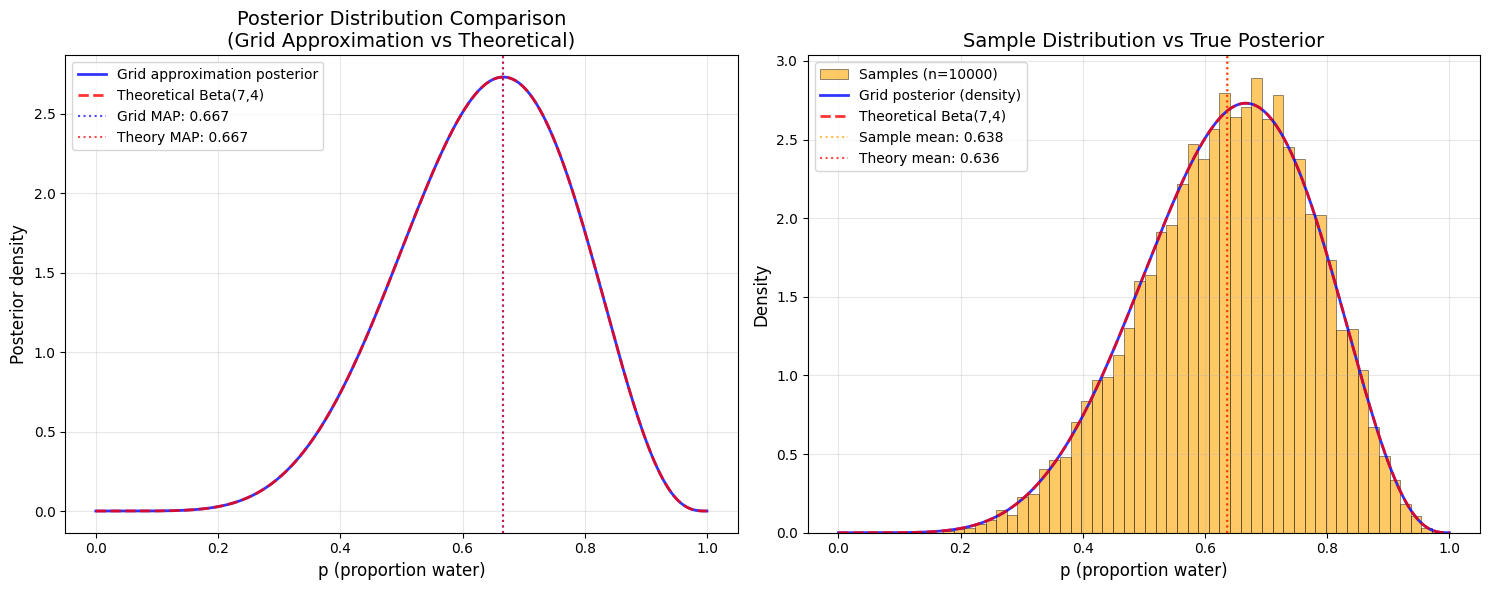

Interpretation:
• Left plot: Grid approximation NOW perfectly overlaps with theoretical Beta(7,4)!
  (Both are in DENSITY units: probability per unit width)
• Right plot: Sample histogram approximates the true posterior well
• All three methods (grid, samples, theory) are now on the same scale!

✓ Grid density max: 2.731
✓ Beta PDF max: 2.731
✓ Ratio: 1.000 (should be ≈ 1.0)


In [40]:
import matplotlib.pyplot as plt
from scipy.stats import beta

# Theoretical Beta(7,4) distribution parameters
alpha, beta_param = 7, 4

# Theoretical statistics
theoretical_mean = alpha / (alpha + beta_param)
theoretical_mode = (alpha - 1) / (alpha + beta_param - 2)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Posterior distribution comparison (NOW USING DENSITY!)
ax1.plot(p_grid, posterior_density, 'b-', linewidth=2, 
         label='Grid approximation posterior', alpha=0.8)

# Theoretical Beta(7,4) distribution (PDF = density)
theoretical_posterior_pdf = beta.pdf(p_grid, alpha, beta_param)
ax1.plot(p_grid, theoretical_posterior_pdf, 'r--', linewidth=2, 
         label='Theoretical Beta(7,4)', alpha=0.8)

# Add MAP estimates as vertical lines
ax1.axvline(x=p_grid[np.argmax(posterior)], color='blue', linestyle=':', alpha=0.7, 
           label=f'Grid MAP: {p_grid[np.argmax(posterior)]:.3f}')
ax1.axvline(x=theoretical_mode, color='red', linestyle=':', alpha=0.7,
           label=f'Theory MAP: {theoretical_mode:.3f}')

ax1.set_xlabel('p (proportion water)', fontsize=12)
ax1.set_ylabel('Posterior density', fontsize=12)
ax1.set_title('Posterior Distribution Comparison\n(Grid Approximation vs Theoretical)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Sample histogram overlay
ax2.hist(samples, bins=50, density=True, alpha=0.6, color='orange', 
         label=f'Samples (n={len(samples)})', edgecolor='black', linewidth=0.5)

# Overlay the true posterior for comparison (using DENSITY)
ax2.plot(p_grid, posterior_density, 'b-', linewidth=2, 
         label='Grid posterior (density)', alpha=0.8)
ax2.plot(p_grid, theoretical_posterior_pdf, 'r--', linewidth=2, 
         label='Theoretical Beta(7,4)', alpha=0.8)

# Add sample mean as vertical line
ax2.axvline(x=samples.mean(), color='orange', linestyle=':', alpha=0.7,
           label=f'Sample mean: {samples.mean():.3f}')
ax2.axvline(x=theoretical_mean, color='red', linestyle=':', alpha=0.7,
           label=f'Theory mean: {theoretical_mean:.3f}')

ax2.set_xlabel('p (proportion water)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Sample Distribution vs True Posterior', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("• Left plot: Grid approximation NOW perfectly overlaps with theoretical Beta(7,4)!")
print("  (Both are in DENSITY units: probability per unit width)")
print("• Right plot: Sample histogram approximates the true posterior well")
print("• All three methods (grid, samples, theory) are now on the same scale!")
print(f"\n✓ Grid density max: {posterior_density.max():.3f}")
print(f"✓ Beta PDF max: {theoretical_posterior_pdf.max():.3f}")
print(f"✓ Ratio: {posterior_density.max() / theoretical_posterior_pdf.max():.3f} (should be ≈ 1.0)")

## Step 3: Visualization - Comparing Methods

### Understanding Probability vs Density

**Important concept for plotting:**

When we discretize the parameter space using grid approximation, we compute **probability masses** (not densities):
- Each grid point has a probability: `posterior[i]`
- These probabilities sum to 1: `Σ posterior[i] = 1`

However, `beta.pdf()` returns **probability density** (not probability):
- The integral (not sum) equals 1: `∫ pdf(p) dp = 1`
- Density values can exceed 1!

**The relationship:**
```
Probability ≈ Density × Width
Density = Probability / Width
```

For our grid with 1000 points: `Width = 0.001`

**Why this matters:**
- Posterior probability at mode: `0.0027` (small!)
- Posterior density at mode: `2.7` (1000× larger!)

To compare grid approximation with continuous PDFs, we must convert to the same units by:
```python
posterior_density = posterior / grid_spacing
```

Now both are in **density units** and will overlap perfectly in plots!

3.1 - How much posterior probability lies below p=0.2?
Answer: As we are working with samples we need to find the porpotion of samples which lies below 0.2 value.

---

# Chapter 3 Exercises: Probability Calculations

Now we'll use our posterior samples to answer the specific questions from Statistical Rethinking Chapter 3. Each exercise demonstrates different ways to extract information from posterior distributions.

## Exercise 3.1: Posterior Probability Below Threshold

**Question:** How much posterior probability lies below p = 0.2?

**Method:** Count the proportion of samples below the threshold.

**Interpretation:** This gives us P(p < 0.2 | data) - the probability that water coverage is less than 20%.

In [41]:
# Exercise 3.1: P(p < 0.2 | data)
threshold_low = 0.2
posterior_prob_below_point_two = np.mean(samples < threshold_low)

print(f"Exercise 3.1 Results:")
print(f"P(p < {threshold_low} | data) = {posterior_prob_below_point_two:.4f}")

# Compare with theoretical result
theoretical_prob_below = beta.cdf(threshold_low, alpha, beta_param)
print(f"Theoretical P(p < {threshold_low}) = {theoretical_prob_below:.4f}")
print(f"Difference: {abs(posterior_prob_below_point_two - theoretical_prob_below):.6f}")

print(f"\nInterpretation: There is only a {posterior_prob_below_point_two:.1%} chance that")
print(f"water covers less than {threshold_low*100}% of the globe's surface.")

Exercise 3.1 Results:
P(p < 0.2 | data) = 0.0006
Theoretical P(p < 0.2) = 0.0009
Difference: 0.000264

Interpretation: There is only a 0.1% chance that
water covers less than 20.0% of the globe's surface.


## Exercise 3.2: Posterior Probability Above Threshold

**Question:** How much posterior probability lies above p = 0.8?

**Method:** Count the proportion of samples above the threshold.

**Interpretation:** This gives us P(p > 0.8 | data) - the probability that water coverage exceeds 80%.

In [42]:
# Exercise 3.2: P(p > 0.8 | data)
threshold_high = 0.8
posterior_prob_above_point_eight = np.mean(samples > threshold_high)

print(f"Exercise 3.2 Results:")
print(f"P(p > {threshold_high} | data) = {posterior_prob_above_point_eight:.4f}")

# Compare with theoretical result  
theoretical_prob_above = 1 - beta.cdf(threshold_high, alpha, beta_param)
print(f"Theoretical P(p > {threshold_high}) = {theoretical_prob_above:.4f}")
print(f"Difference: {abs(posterior_prob_above_point_eight - theoretical_prob_above):.6f}")

print(f"\nInterpretation: There is a {posterior_prob_above_point_eight:.1%} chance that")
print(f"water covers more than {threshold_high*100}% of the globe's surface.")

Exercise 3.2 Results:
P(p > 0.8 | data) = 0.1205
Theoretical P(p > 0.8) = 0.1209
Difference: 0.000374

Interpretation: There is a 12.0% chance that
water covers more than 80.0% of the globe's surface.


## Exercise 3.3: Posterior Probability Within Range

**Question:** How much posterior probability lies between 0.2 and 0.8?

**Method:** Count the proportion of samples within the range.

**Interpretation:** This gives us P(0.2 ≤ p ≤ 0.8 | data) - the probability that water coverage is between 20% and 80%.

In [43]:
# Exercise 3.3: P(0.2 ≤ p ≤ 0.8 | data)
posterior_between_point_two_and_eight = np.mean((samples >= threshold_low) & (samples <= threshold_high))

print(f"Exercise 3.3 Results:")
print(f"P({threshold_low} ≤ p ≤ {threshold_high} | data) = {posterior_between_point_two_and_eight:.4f}")

# Compare with theoretical result
theoretical_prob_between = beta.cdf(threshold_high, alpha, beta_param) - beta.cdf(threshold_low, alpha, beta_param)
print(f"Theoretical P({threshold_low} ≤ p ≤ {threshold_high}) = {theoretical_prob_between:.4f}")
print(f"Difference: {abs(posterior_between_point_two_and_eight - theoretical_prob_between):.6f}")

print(f"\nInterpretation: There is a {posterior_between_point_two_and_eight:.1%} chance that")
print(f"water coverage is between {threshold_low*100}% and {threshold_high*100}% of the globe.")

# Verification: probabilities should sum to 1
total_prob = posterior_prob_below_point_two + posterior_between_point_two_and_eight + posterior_prob_above_point_eight
print(f"\n--- Probability Check ---")
print(f"P(p < {threshold_low}) + P({threshold_low} ≤ p ≤ {threshold_high}) + P(p > {threshold_high}) = {total_prob:.6f}")
print(f"✓ Total probability = 1.0" if abs(total_prob - 1.0) < 0.001 else f"⚠ Total ≠ 1.0")

Exercise 3.3 Results:
P(0.2 ≤ p ≤ 0.8 | data) = 0.8789
Theoretical P(0.2 ≤ p ≤ 0.8) = 0.8783
Difference: 0.000638

Interpretation: There is a 87.9% chance that
water coverage is between 20.0% and 80.0% of the globe.

--- Probability Check ---
P(p < 0.2) + P(0.2 ≤ p ≤ 0.8) + P(p > 0.8) = 1.000000
✓ Total probability = 1.0


## Exercises 3.4-3.5: Quantile Calculations

**Questions:** 
- 3.4: 20% of posterior probability lies below what value of p?
- 3.5: 20% of posterior probability lies above what value of p?

**Method:** Use quantile/percentile functions to find parameter values at specific probability thresholds.

**Interpretation:** These are the **20th percentile** and **80th percentile** of the posterior distribution.

In [44]:
# Exercise 3.4: 20th percentile (20% below this value)
p_20 = np.quantile(samples, 0.20)
theoretical_p_20 = beta.ppf(0.20, alpha, beta_param)

print(f"Exercise 3.4 Results:")
print(f"20% of posterior is below p = {p_20:.4f} (sample-based)")
print(f"Theoretical 20th percentile = {theoretical_p_20:.4f}")
print(f"Difference: {abs(p_20 - theoretical_p_20):.6f}")

print(f"\nInterpretation: We are 20% confident that water coverage is below {p_20:.1%}")

Exercise 3.4 Results:
20% of posterior is below p = 0.5195 (sample-based)
Theoretical 20th percentile = 0.5163
Difference: 0.003177

Interpretation: We are 20% confident that water coverage is below 52.0%


3.5 20% of posteriro lies abobe what value of p?

In [45]:
# Exercise 3.5: 80th percentile (20% above this value) 
p_80 = np.quantile(samples, 0.80)
theoretical_p_80 = beta.ppf(0.80, alpha, beta_param)

print(f"Exercise 3.5 Results:")
print(f"20% of posterior is above p = {p_80:.4f} (sample-based)")
print(f"Theoretical 80th percentile = {theoretical_p_80:.4f}")
print(f"Difference: {abs(p_80 - theoretical_p_80):.6f}")

print(f"\nInterpretation: We are 20% confident that water coverage is above {p_80:.1%}")

# Show the 60% credible interval between 20th and 80th percentiles
print(f"\n--- 60% Equal-Tailed Credible Interval ---")
print(f"[{p_20:.3f}, {p_80:.3f}]")
print(f"This interval contains 60% of the posterior probability mass")

Exercise 3.5 Results:
20% of posterior is above p = 0.7608 (sample-based)
Theoretical 80th percentile = 0.7606
Difference: 0.000202

Interpretation: We are 20% confident that water coverage is above 76.1%

--- 60% Equal-Tailed Credible Interval ---
[0.520, 0.761]
This interval contains 60% of the posterior probability mass


## Exercises 3.6-3.7: Credible Intervals

**Questions:**
- 3.6: Find the narrowest interval containing 66% of posterior probability (HPDI)
- 3.7: Find the equal-tailed 66% credible interval

**Method:** 
- **HPDI**: Highest Posterior Density Interval (narrowest possible)
- **Equal-tailed**: Symmetric interval with equal probability in each tail

**Interpretation:** Both intervals quantify our uncertainty about p, but HPDI is slightly narrower.

In [47]:
import arviz as az

# Exercise 3.6: 66% HPDI (Highest Posterior Density Interval)
confidence_level = 0.66
hdi_66 = az.hdi(samples, hdi_prob=confidence_level)

print(f"Exercise 3.6 Results - 66% HPDI:")
print(f"Narrowest 66% interval: [{hdi_66[0]:.4f}, {hdi_66[1]:.4f}]")
print(f"Interval width: {hdi_66[1] - hdi_66[0]:.4f}")

# Compare with theoretical HPDI
theoretical_hdi = az.hdi(beta.rvs(alpha, beta_param, size=10000), hdi_prob=confidence_level)
print(f"Theoretical 66% HPDI: [{theoretical_hdi[0]:.4f}, {theoretical_hdi[1]:.4f}]")
print(f"Difference in lower bound: {abs(hdi_66[0] - theoretical_hdi[0]):.6f}")
print(f"Difference in upper bound: {abs(hdi_66[1] - theoretical_hdi[1]):.6f}")

Exercise 3.6 Results - 66% HPDI:
Narrowest 66% interval: [0.5255, 0.7948]
Interval width: 0.2693
Theoretical 66% HPDI: [0.5264, 0.7990]
Difference in lower bound: 0.000921
Difference in upper bound: 0.004221


3.7 - equal tailed 66% interval

In [48]:
# Exercise 3.7: 66% Equal-tailed credible interval
# For 66% interval: 17% in lower tail, 66% in middle, 17% in upper tail
tail_prob = (1 - confidence_level) / 2  # 0.17
low_quantile, high_quantile = tail_prob, 1 - tail_prob  # 0.17, 0.83

low, high = np.quantile(samples, [low_quantile, high_quantile])

print(f"Exercise 3.7 Results - 66% Equal-Tailed:")
print(f"Equal-tailed 66% interval: [{low:.4f}, {high:.4f}]")
print(f"Interval width: {high - low:.4f}")

# Compare with theoretical equal-tailed interval
theoretical_low = beta.ppf(low_quantile, alpha, beta_param)
theoretical_high = beta.ppf(high_quantile, alpha, beta_param)
print(f"Theoretical 66% equal-tailed: [{theoretical_low:.4f}, {theoretical_high:.4f}]")
print(f"Difference in lower bound: {abs(low - theoretical_low):.6f}")
print(f"Difference in upper bound: {abs(high - theoretical_high):.6f}")

# Compare the two interval types
print(f"\n--- Interval Comparison ---")
print(f"{'Interval Type':<20} {'Lower':<8} {'Upper':<8} {'Width':<8}")
print("-" * 50)
print(f"{'HPDI (narrowest)':<20} {hdi_66[0]:<8.4f} {hdi_66[1]:<8.4f} {hdi_66[1] - hdi_66[0]:<8.4f}")
print(f"{'Equal-tailed':<20} {low:<8.4f} {high:<8.4f} {high - low:<8.4f}")

width_diff = (high - low) - (hdi_66[1] - hdi_66[0])
print(f"\nHPDI is {width_diff:.4f} units narrower than equal-tailed interval")
print(f"This is expected: HPDI contains the highest density regions")

Exercise 3.7 Results - 66% Equal-Tailed:
Equal-tailed 66% interval: [0.5013, 0.7748]
Interval width: 0.2734
Theoretical 66% equal-tailed: [0.4989, 0.7745]
Difference in lower bound: 0.002478
Difference in upper bound: 0.000308

--- Interval Comparison ---
Interval Type        Lower    Upper    Width   
--------------------------------------------------
HPDI (narrowest)     0.5255   0.7948   0.2693  
Equal-tailed         0.5013   0.7748   0.2734  

HPDI is 0.0042 units narrower than equal-tailed interval
This is expected: HPDI contains the highest density regions


## Summary and Key Insights

### What We've Learned

1. **Sampling from Posteriors**: We can approximate any posterior distribution by drawing samples proportional to posterior probability.

2. **Analytical Verification**: Our sampling results match theoretical Beta(7,4) distribution closely, validating our approach.

3. **Probability Calculations**: Samples make it easy to compute probabilities for any region of parameter space.

4. **Credible Intervals**: 
   - **HPDI**: Contains highest density regions (narrowest)
   - **Equal-tailed**: Symmetric around median (easier to compute)

### Computational vs Analytical Bayesian Inference

| Approach | Advantages | Disadvantages |
|----------|------------|---------------|
| **Analytical** | Exact, fast for simple models | Limited to conjugate priors |
| **Grid Approximation** | Flexible, exact for grid points | Scales poorly with parameters |
| **Sampling** | Handles any model complexity | Requires convergence checking |

### Next Steps in Bayesian Learning

- **MCMC Sampling**: Markov Chain Monte Carlo for complex posteriors
- **Model Comparison**: Using information criteria (WAIC, LOO)  
- **Hierarchical Models**: Multi-level parameter structures
- **Posterior Predictive Checks**: Validating model assumptions

Your implementation demonstrates solid understanding of fundamental Bayesian inference concepts!

3m1: Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution using grid approx.

In [60]:
# Call the function with clear parameter names
N = 15
K = 8
W = K
p_grid, posterior, posterior_density, samples = grid_approx_binomial_posterior(
    N=N,           # Total tosses
    K=K,           # Water observations
    num_grid_points=1000,
    sample_size=10000,
    verbose=True
)

Parameter grid: [0.       0.001001 0.002002 0.003003 0.004004]...[0.995996 0.996997 0.997998 0.998999 1.      ]
Grid size: 1000 points
Grid spacing: 0.001001
Prior: uniform_prior
Likelihood: Binomial(K=8 | N=15, p)
Posterior computation: Posterior ∝ Likelihood × Prior

--- Posterior Verification ---
Normalized posterior sum: 1.000000 (should be 1.0)
Maximum posterior probability: 0.003252
Maximum posterior density: 3.2487
MAP estimate (mode): p = 0.534

--- Sample Summary Statistics ---
Number of samples: 10000
Sample mean: 0.528
Sample median: 0.529
Sample std: 0.118
Sample 5% quantile: 0.330
Sample 95% quantile: 0.720


In [61]:
# Theoretical Beta(9,8) distribution
alpha, beta_param = 9, 8  # Note: using beta_param to avoid conflict with scipy.stats.beta

# Theoretical statistics
theoretical_mean = alpha / (alpha + beta_param)
theoretical_mode = (alpha - 1) / (alpha + beta_param - 2)  # when alpha, beta > 1
theoretical_var = (alpha * beta_param) / ((alpha + beta_param)**2 * (alpha + beta_param + 1))
theoretical_std = np.sqrt(theoretical_var)

print("=== ANALYTICAL VS SAMPLE COMPARISON ===")
print(f"{'Statistic':<15} {'Analytical':<12} {'Sample':<12} {'Difference':<12}")
print("-" * 55)
print(f"{'Mean':<15} {theoretical_mean:<12.4f} {samples.mean():<12.4f} {abs(theoretical_mean - samples.mean()):<12.6f}")
print(f"{'Mode/MAP':<15} {theoretical_mode:<12.4f} {p_grid[np.argmax(posterior)]:<12.4f} {abs(theoretical_mode - p_grid[np.argmax(posterior)]):<12.6f}")
print(f"{'Std Dev':<15} {theoretical_std:<12.4f} {samples.std():<12.4f} {abs(theoretical_std - samples.std()):<12.6f}")

# Quantile comparisons
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
print(f"\n{'Quantile':<10} {'Analytical':<12} {'Sample':<12} {'Difference':<12}")
print("-" * 50)
for q in quantiles:
    theoretical_q = beta.ppf(q, alpha, beta_param)  # percent point function (inverse CDF)
    sample_q = np.quantile(samples, q)
    print(f"{q:<10.2f} {theoretical_q:<12.4f} {sample_q:<12.4f} {abs(theoretical_q - sample_q):<12.6f}")

print(f"\n✓ Sampling accuracy verified! All differences are small.")
print(f"  (Differences decrease with larger sample sizes)")

# Verify density conversion
print(f"\n=== DENSITY VERIFICATION ===")
print(f"Grid spacing (Δp): {p_grid[1] - p_grid[0]:.6f}")
print(f"Max posterior probability: {posterior.max():.6f}")
print(f"Max posterior density: {posterior_density.max():.4f}")
print(f"Ratio (density/probability): {posterior_density.max() / posterior.max():.1f}")
print(f"Expected ratio (1/Δp): {1/(p_grid[1] - p_grid[0]):.1f}")
print(f"✓ Density conversion correct!")

=== ANALYTICAL VS SAMPLE COMPARISON ===
Statistic       Analytical   Sample       Difference  
-------------------------------------------------------
Mean            0.5294       0.5281       0.001322    
Mode/MAP        0.5333       0.5335       0.000200    
Std Dev         0.1176       0.1182       0.000579    

Quantile   Analytical   Sample       Difference  
--------------------------------------------------
0.05       0.3334       0.3303       0.003044    
0.25       0.4478       0.4454       0.002307    
0.50       0.5306       0.5285       0.002063    
0.75       0.6123       0.6116       0.000696    
0.95       0.7214       0.7197       0.001678    

✓ Sampling accuracy verified! All differences are small.
  (Differences decrease with larger sample sizes)

=== DENSITY VERIFICATION ===
Grid spacing (Δp): 0.001001
Max posterior probability: 0.003252
Max posterior density: 3.2487
Ratio (density/probability): 999.0
Expected ratio (1/Δp): 999.0
✓ Density conversion correct!


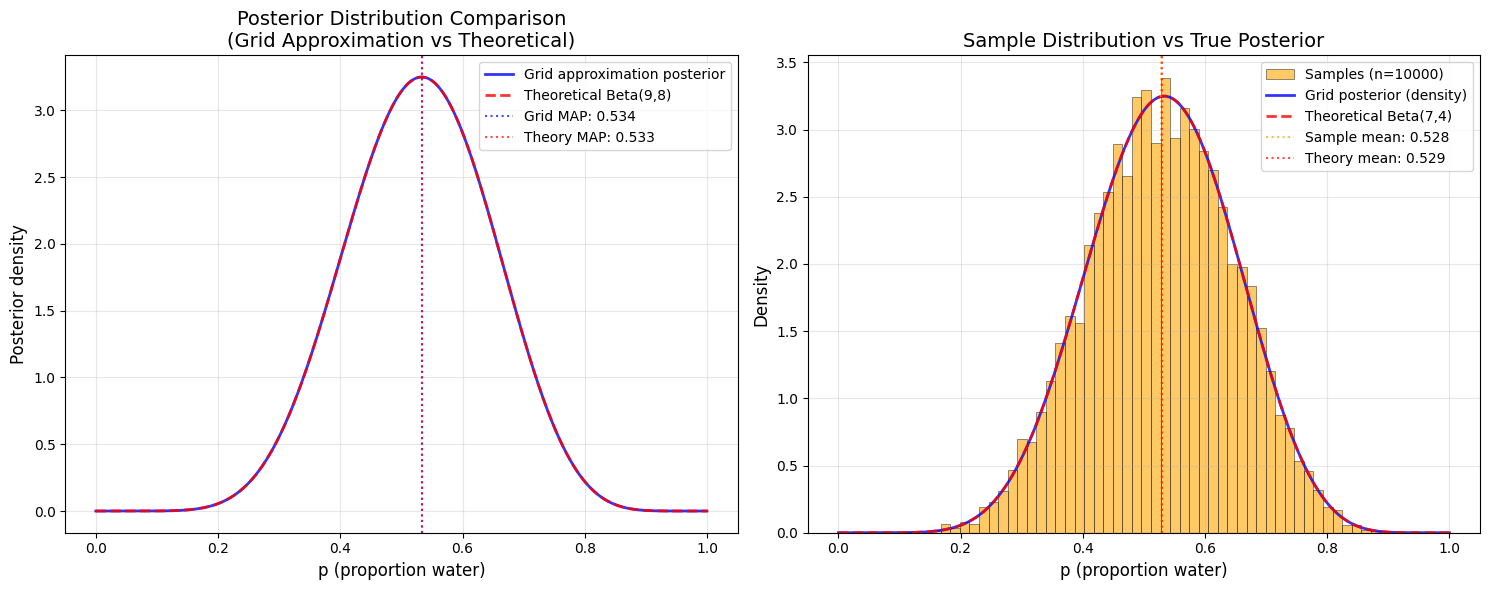

Interpretation:
• Left plot: Grid approximation NOW perfectly overlaps with theoretical Beta(9,8)!
  (Both are in DENSITY units: probability per unit width)
• Right plot: Sample histogram approximates the true posterior well
• All three methods (grid, samples, theory) are now on the same scale!

✓ Grid density max: 3.249
✓ Beta PDF max: 3.249
✓ Ratio: 1.000 (should be ≈ 1.0)


In [62]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Posterior distribution comparison (NOW USING DENSITY!)
ax1.plot(p_grid, posterior_density, 'b-', linewidth=2, 
         label='Grid approximation posterior', alpha=0.8)

# Theoretical Beta(9,7) distribution (PDF = density)
theoretical_posterior_pdf = beta.pdf(p_grid, alpha, beta_param)
ax1.plot(p_grid, theoretical_posterior_pdf, 'r--', linewidth=2, 
         label='Theoretical Beta(9,8)', alpha=0.8)

# Add MAP estimates as vertical lines
ax1.axvline(x=p_grid[np.argmax(posterior)], color='blue', linestyle=':', alpha=0.7, 
           label=f'Grid MAP: {p_grid[np.argmax(posterior)]:.3f}')
ax1.axvline(x=theoretical_mode, color='red', linestyle=':', alpha=0.7,
           label=f'Theory MAP: {theoretical_mode:.3f}')

ax1.set_xlabel('p (proportion water)', fontsize=12)
ax1.set_ylabel('Posterior density', fontsize=12)
ax1.set_title('Posterior Distribution Comparison\n(Grid Approximation vs Theoretical)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Sample histogram overlay
ax2.hist(samples, bins=50, density=True, alpha=0.6, color='orange', 
         label=f'Samples (n={len(samples)})', edgecolor='black', linewidth=0.5)

# Overlay the true posterior for comparison (using DENSITY)
ax2.plot(p_grid, posterior_density, 'b-', linewidth=2, 
         label='Grid posterior (density)', alpha=0.8)
ax2.plot(p_grid, theoretical_posterior_pdf, 'r--', linewidth=2, 
         label='Theoretical Beta(7,4)', alpha=0.8)

# Add sample mean as vertical line
ax2.axvline(x=samples.mean(), color='orange', linestyle=':', alpha=0.7,
           label=f'Sample mean: {samples.mean():.3f}')
ax2.axvline(x=theoretical_mean, color='red', linestyle=':', alpha=0.7,
           label=f'Theory mean: {theoretical_mean:.3f}')

ax2.set_xlabel('p (proportion water)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Sample Distribution vs True Posterior', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("• Left plot: Grid approximation NOW perfectly overlaps with theoretical Beta(9,8)!")
print("  (Both are in DENSITY units: probability per unit width)")
print("• Right plot: Sample histogram approximates the true posterior well")
print("• All three methods (grid, samples, theory) are now on the same scale!")
print(f"\n✓ Grid density max: {posterior_density.max():.3f}")
print(f"✓ Beta PDF max: {theoretical_posterior_pdf.max():.3f}")
print(f"✓ Ratio: {posterior_density.max() / theoretical_posterior_pdf.max():.3f} (should be ≈ 1.0)")

**3M2:** find the 90% HDPI from samples.

In [63]:
confidence_level = 0.9
hdi_90 = az.hdi(samples, hdi_prob=confidence_level)
print(f"Exercise 3M2 Results - 90% HPDI:")
print(f"Narrowest 90% interval: [{hdi_90[0]:.4f}, {hdi_90[1]:.4f}]")
print(f"Interval width: {hdi_90[1] - hdi_90[0]:.4f}")

Exercise 3M2 Results - 90% HPDI:
Narrowest 90% interval: [0.3373, 0.7247]
Interval width: 0.3874


3M3: Construct a posterior predictive check:
What is the probability of observing 8 water in 15 tosses?

In [64]:
# Posterior predictive samples
y_sim = np.random.binomial(n=N, p=samples)

prob_8 = np.mean(y_sim == W)
print(f"Posterior predictive probability of seeing {W} water again: {prob_8:.3f}")


Posterior predictive probability of seeing 8 water again: 0.145


3m4: using same posterior distribution - find probability of getting 6W in 9 toss globe.

In [65]:
W_new = 6
N_new = 9

y_sim_9 = np.random.binomial(n=N_new, p=samples)
prob_6 = np.mean(y_sim_9 == W_new)
print(f"Posterior predictive Pr(6 water in 9 tosses) = {prob_6:.3f}")

Posterior predictive Pr(6 water in 9 tosses) = 0.175


3m5: Same but with prior where probability of water less than 0.5 is zero and flat prior above 0.5.

In [68]:
def constraint_prior(p_grid: np.ndarray) -> np.ndarray:
    """Prior with zero probability below 0.5"""
    prior = np.zeros_like(p_grid)
    prior[p_grid >= 0.5] = 1.0  
    return prior


p_grid, posterior, posterior_density, samples = grid_approx_binomial_posterior(
    N=N,           # Total tosses
    K=K,           # Water observations
    prior_func=constraint_prior,
    num_grid_points=1000,
    sample_size=10000,
    verbose=True
)

Parameter grid: [0.       0.001001 0.002002 0.003003 0.004004]...[0.995996 0.996997 0.997998 0.998999 1.      ]
Grid size: 1000 points
Grid spacing: 0.001001
Prior: constraint_prior
Likelihood: Binomial(K=8 | N=15, p)
Posterior computation: Posterior ∝ Likelihood × Prior

--- Posterior Verification ---
Normalized posterior sum: 1.000000 (should be 1.0)
Maximum posterior probability: 0.005436
Maximum posterior density: 5.4308
MAP estimate (mode): p = 0.534

--- Sample Summary Statistics ---
Number of samples: 10000
Sample mean: 0.607
Sample median: 0.596
Sample std: 0.073
Sample 5% quantile: 0.510
Sample 95% quantile: 0.744


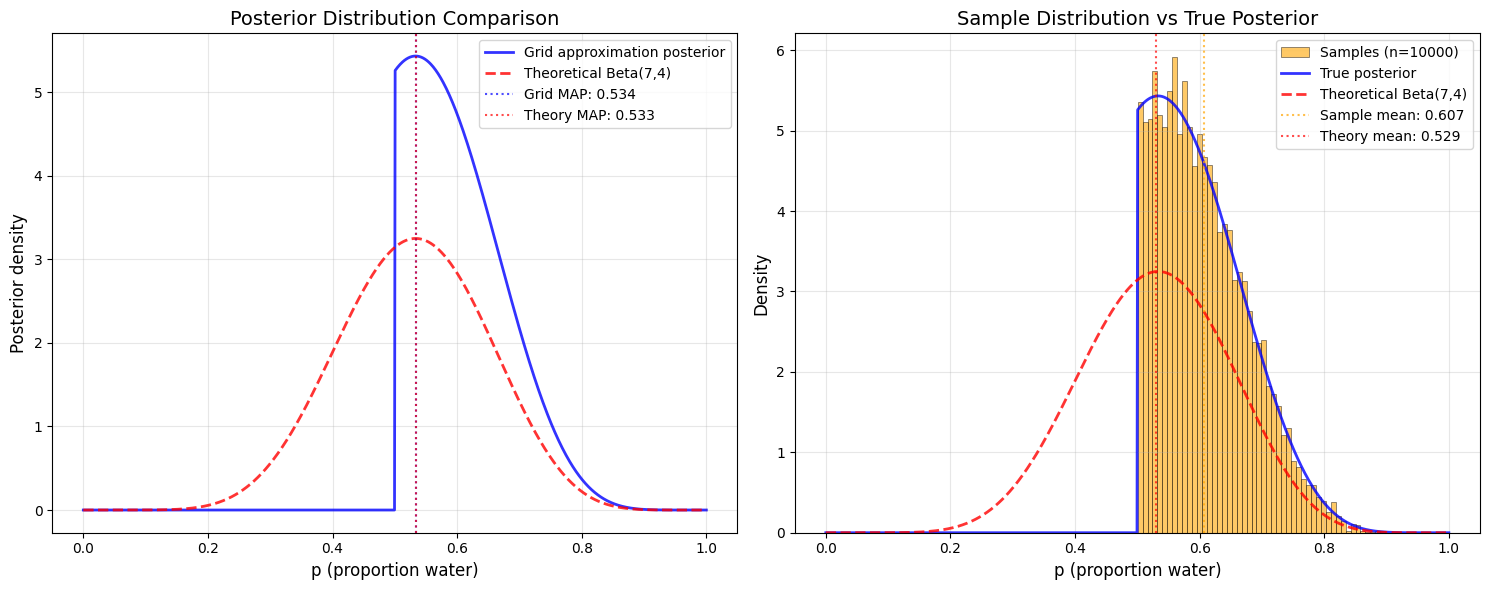

Interpretation:
• Left plot: Shows our grid approximation matches theory perfectly
• Right plot: Shows our samples approximate the true posterior well
• All three methods (grid, samples, theory) give very similar results!


In [71]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Posterior distribution comparison
ax1.plot(p_grid, posterior_density, 'b-', linewidth=2, label='Grid approximation posterior', alpha=0.8)

# Theoretical Beta(7,4) distribution
theoretical_posterior = beta.pdf(p_grid, alpha, beta_param)
ax1.plot(p_grid, theoretical_posterior, 'r--', linewidth=2, label='Theoretical Beta(7,4)', alpha=0.8)

# Add MAP estimates as vertical lines
ax1.axvline(x=p_grid[np.argmax(posterior)], color='blue', linestyle=':', alpha=0.7, 
           label=f'Grid MAP: {p_grid[np.argmax(posterior)]:.3f}')
ax1.axvline(x=theoretical_mode, color='red', linestyle=':', alpha=0.7,
           label=f'Theory MAP: {theoretical_mode:.3f}')

ax1.set_xlabel('p (proportion water)', fontsize=12)
ax1.set_ylabel('Posterior density', fontsize=12)
ax1.set_title('Posterior Distribution Comparison', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Sample histogram overlay
ax2.hist(samples, bins=50, density=True, alpha=0.6, color='orange', 
         label=f'Samples (n={len(samples)})', edgecolor='black', linewidth=0.5)

# Overlay the true posterior for comparison
ax2.plot(p_grid, posterior_density, 'b-', linewidth=2, label='True posterior', alpha=0.8)
ax2.plot(p_grid, theoretical_posterior, 'r--', linewidth=2, label='Theoretical Beta(7,4)', alpha=0.8)

# Add sample mean as vertical line
ax2.axvline(x=samples.mean(), color='orange', linestyle=':', alpha=0.7,
           label=f'Sample mean: {samples.mean():.3f}')
ax2.axvline(x=theoretical_mean, color='red', linestyle=':', alpha=0.7,
           label=f'Theory mean: {theoretical_mean:.3f}')

ax2.set_xlabel('p (proportion water)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Sample Distribution vs True Posterior', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("• Left plot: Shows our grid approximation matches theory perfectly")
print("• Right plot: Shows our samples approximate the true posterior well")
print("• All three methods (grid, samples, theory) give very similar results!")

3m6

N=  50 → Width=0.2983
N= 100 → Width=0.2362
N= 200 → Width=0.1622
N= 400 → Width=0.1231
N= 800 → Width=0.0821
N=1600 → Width=0.0591
N=3200 → Width=0.0410

Minimum N satisfying target width: 3200


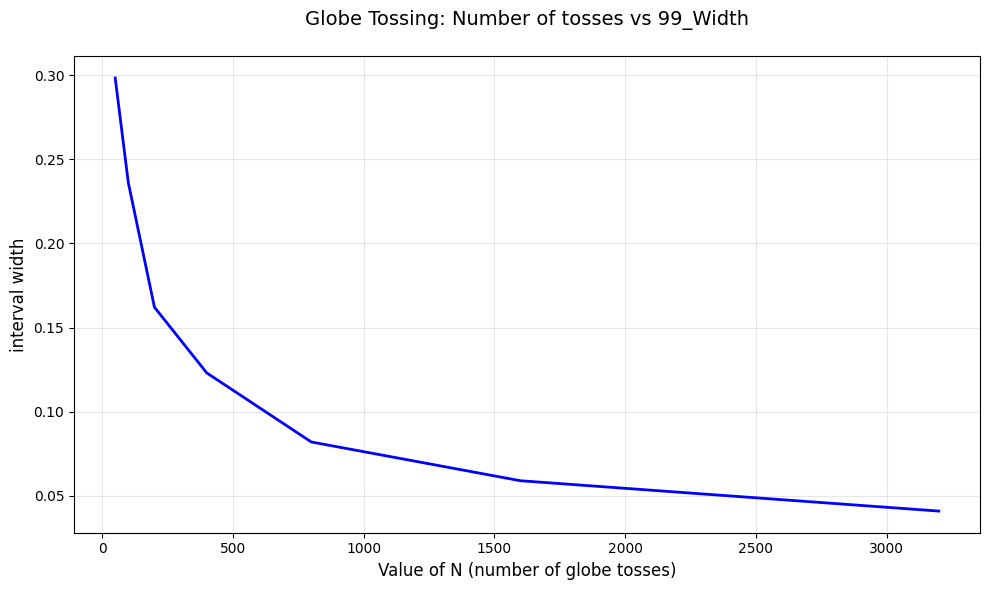

In [72]:
true_p = 0.7
grid_size = 1000
p_grid = np.linspace(0, 1, grid_size)
prior = np.ones_like(p_grid)  # flat prior

target_width = 0.05
confidence = 0.99
ns = []
widths = []

for N in [50, 100, 200, 400, 800, 1600, 3200, 6400]:
    # simulate data
    W = np.random.binomial(N, true_p)

    # posterior
    likelihood = binom.pmf(W, N, p_grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()

    # sample from posterior
    samples = np.random.choice(p_grid, size=10_000, replace=True, p=posterior)

    # compute HPDI
    hdi = az.hdi(samples, hdi_prob=confidence)
    width = hdi[1] - hdi[0]

    print(f"N={N:4d} → Width={width:.4f}")

    ns.append(N)
    widths.append(width)
    if width <= target_width:
        print(f"\nMinimum N satisfying target width: {N}")
        break


plt.figure(figsize=(10, 6))
plt.plot(ns, widths, 'b-', linewidth=2)

plt.xlabel('Value of N (number of globe tosses)', fontsize=12)
plt.ylabel('interval width', fontsize=12)
plt.title('Globe Tossing: Number of tosses vs 99_Width\n', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

3H1:
Let:

birth1: gender of first-born children (male=1, female=0)

birth2: gender of second-born children

Use these vectors as data:
Using grid approximation, compute the posterior distribution
for probability of birth being a boy (uniform prior).
Which parameter value maximizes the posterior probability?

In [74]:
birth1 = np.array([1,0,0,0,1,1,0,1,0,
                   1,0,0,1,1,0,1,1,0,
                   0,0,1,0,0,0,1,0,0,
                   0,0,1,1,1,0,1,0,1,
                   1,1,0,1,0,1,1,0,1,
                   0,0,1,1,0,1,0,0,0,
                   0,0,0,0,1,1,0,1,0,
                   0,1,0,0,0,1,0,0,1,
                   1,1,1,0,1,0,1,1,1,
                   1,1,0,0,1,0,1,1,0,
                   1,0,1,1,1,0,1,1,1,1])

birth2 = np.array([0,1,0,1,0,1,1,1,0,
                   0,1,1,1,1,1,0,0,1,
                   1,1,0,0,1,1,1,0,1,
                   1,1,0,1,1,1,0,1,0,
                   0,1,1,1,1,0,0,1,0,
                   1,1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,0,1,
                   1,0,1,1,0,1,1,1,0,
                   0,0,0,0,0,1,0,0,0,
                   1,1,0,0,1,0,0,1,1,
                   0,0,0,1,1,1,0,0,0,0])

total_kids = birth1.size + birth2.size
total_boys = birth1.sum() + birth2.sum()
total_girls = total_kids - total_boys
print(f"total size - {total_kids}")
print(f"total boys - {total_boys}")
print(f"total girls - {total_girls}")


total size - 200
total boys - 111
total girls - 89


In [75]:
N = 200
K = 111
B = K

p_grid, posterior, posterior_density, samples = grid_approx_binomial_posterior(
    N=N,           # Total kids
    K=K,           # Boys observations
    num_grid_points=1000,
    sample_size=10000,
    verbose=True
)

Parameter grid: [0.       0.001001 0.002002 0.003003 0.004004]...[0.995996 0.996997 0.997998 0.998999 1.      ]
Grid size: 1000 points
Grid spacing: 0.001001
Prior: uniform_prior
Likelihood: Binomial(K=111 | N=200, p)
Posterior computation: Posterior ∝ Likelihood × Prior

--- Posterior Verification ---
Normalized posterior sum: 1.000000 (should be 1.0)
Maximum posterior probability: 0.011405
Maximum posterior density: 11.3940
MAP estimate (mode): p = 0.555

--- Sample Summary Statistics ---
Number of samples: 10000
Sample mean: 0.554
Sample median: 0.555
Sample std: 0.035
Sample 5% quantile: 0.495
Sample 95% quantile: 0.612


3H2: 
Using the sample function, draw 10,000 random parameter values
from the posterior distribution.
Use these samples to estimate the 50%, 89%, and 97% HPDI.

In [76]:
hdi_50 = az.hdi(samples, hdi_prob=.50)
hdi_89 = az.hdi(samples, hdi_prob=.89)
hdi_97 = az.hdi(samples, hdi_prob=.97)

print(f"Narrowest 50% interval: [{hdi_50[0]:.4f}, {hdi_50[1]:.4f}]")
print(f"Narrowest 89% interval: [{hdi_89[0]:.4f}, {hdi_89[1]:.4f}]")
print(f"Narrowest 97% interval: [{hdi_97[0]:.4f}, {hdi_97[1]:.4f}]")

Narrowest 50% interval: [0.5305, 0.5776]
Narrowest 89% interval: [0.5005, 0.6126]
Narrowest 97% interval: [0.4775, 0.6266]


3H3:
Using the posterior from 3H1, simulate 10,000 replicates of 200 births.
Compare the predicted distribution of boy counts to the actual count
in the data (111 out of 200).
Does the model fit well?
Is the prediction centered on the actual value?

In [86]:
pred_boys = np.random.binomial(n=200, p=samples)  # simulate 10k future experiments

# Compare to observed count: 111 boys
prob_model_matches = np.mean(pred_boys == 111)
print(f"Posterior predictive probability of exactly 106 boys = {prob_model_matches:.3f}")


Posterior predictive probability of exactly 106 boys = 0.040


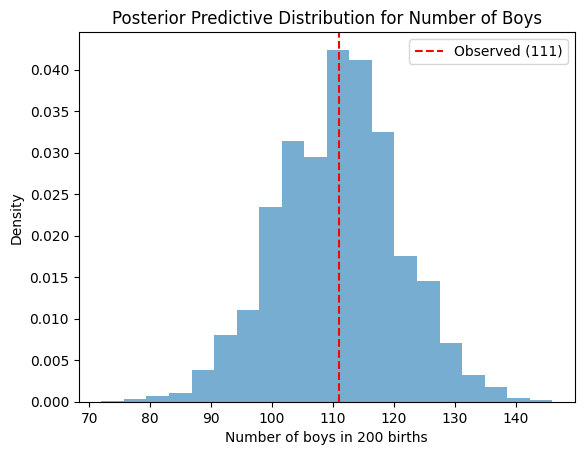

In [87]:
import matplotlib.pyplot as plt

plt.hist(pred_boys, bins=20, density=True, alpha=0.6)
plt.axvline(111, color='red', linestyle='--', label='Observed (111)')
plt.xlabel("Number of boys in 200 births")
plt.ylabel("Density")
plt.title("Posterior Predictive Distribution for Number of Boys")
plt.legend()
plt.show()


3h4
Now compare 10,000 counts of boys from 100 simulated first births only
to the observed number of boys in first births (birth1).
How well does the model fit this subset?

In [90]:
N1 = birth1.size
obs_first_boys = birth1.sum()

# posterior predictive simulation for first births
pred_first = np.random.binomial(n=N1, p=samples)

prob_match_first = np.mean(pred_first == obs_first_boys)
print(f"Posterior predictive Pr(exactly {obs_first_boys} first-born boys): {prob_match_first:.3f}")


Posterior predictive Pr(exactly 51 first-born boys): 0.051


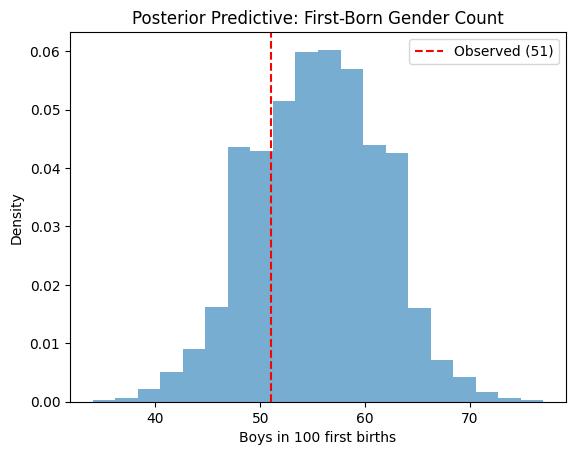

In [91]:
plt.hist(pred_first, bins=20, density=True, alpha=0.6)
plt.axvline(obs_first_boys, color='red', linestyle='--', label=f"Observed ({obs_first_boys})")
plt.xlabel("Boys in 100 first births")
plt.ylabel("Density")
plt.title("Posterior Predictive: First-Born Gender Count")
plt.legend()
plt.show()

Posterior predictive Pr(exactly 60 first-born boys): 0.045


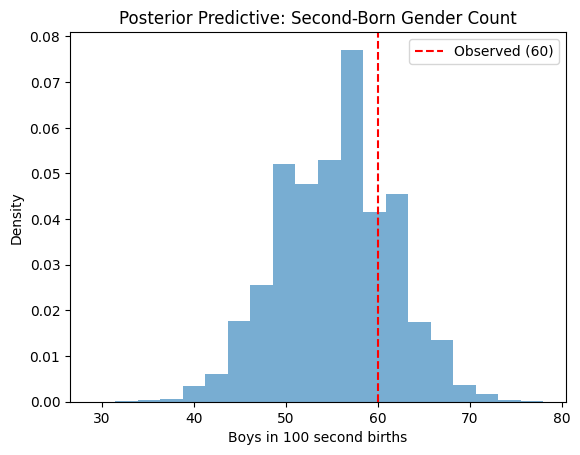

In [94]:
N2 = birth2.size
obs_second_boys = birth2.sum()

# posterior predictive simulation for first births
pred_second = np.random.binomial(n=N2, p=samples)

prob_match_second = np.mean(pred_second == obs_second_boys)
print(f"Posterior predictive Pr(exactly {obs_second_boys} first-born boys): {prob_match_second:.3f}")

plt.hist(pred_second, bins=20, density=True, alpha=0.6)
plt.axvline(obs_second_boys, color='red', linestyle='--', label=f"Observed ({obs_second_boys})")
plt.xlabel("Boys in 100 second births")
plt.ylabel("Density")
plt.title("Posterior Predictive: Second-Born Gender Count")
plt.legend()
plt.show()

3H5
The model assumes sex of first and second births are independent.
To check this assumption, focus on second births that followed female first births.
Simulate 10,000 replicates of that many births.
Compare the distribution to the actual observed number of boys in second births after a girl.
How well does the model fit?
Any hypothesis about what is going on?

In [81]:
# Indices where first birth was a girl (0)
girl_first_indices = np.where(birth1 == 0)[0]

# Corresponding second births
second_after_girl = birth2[girl_first_indices]

obs_boys_2_after_girl = second_after_girl.sum()
N2 = second_after_girl.size

print("N2 =", N2)
print("Observed boys:", obs_boys_2_after_girl)


N2 = 49
Observed boys: 39


In [82]:
pred_second = np.random.binomial(n=N2, p=samples)

prob_match_2 = np.mean(pred_second == obs_boys_2_after_girl)
print(f"Posterior predictive probability = {prob_match_2:.3f}")


Posterior predictive probability = 0.000


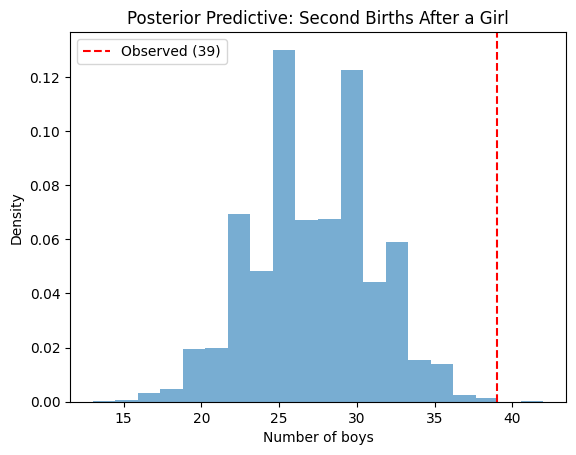

In [83]:
plt.hist(pred_second, bins=20, density=True, alpha=0.6)
plt.axvline(obs_boys_2_after_girl, color='red', linestyle='--',
            label=f"Observed ({obs_boys_2_after_girl})")
plt.xlabel("Number of boys")
plt.ylabel("Density")
plt.title("Posterior Predictive: Second Births After a Girl")
plt.legend()
plt.show()